In [ ]:
#access gdrive folder: 20_440Project_JS_TF_AMB must be in MyDrive
from google.colab import drive

drive.mount("/content/drive")
%cd /content/drive/My Drive/20_440Project_JS_TF_AMB

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/11ayn8NvvhQcP_j3xRQ6p0HIXj3agZbuK/20_440Project_JS_TF_AMB


# Install and load dependencies

In [ ]:
%pip install pydeseq2
%pip install scanpy
%pip install sanbomics
%pip install bioinfokit
%pip install gseapy

In [ ]:
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
from functools import reduce
from sanbomics.plots import volcano
from bioinfokit import analys,visuz
from gseapy.plot import gseaplot


import pandas as pd
import seaborn as sns
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import sys
import gseapy as gp

sys.setrecursionlimit(10000)  # Set a higher recursion limit (adjust the value as needed)

# Run DeSeq2

In [ ]:
merged = pd.read_csv('new_primary_TF/primary_unDiffs.tsv', delimiter='\t')
merged.set_index(merged.columns[0], inplace=True)
merged.sort_index(inplace=True)
merged *= 100
merged = merged.astype(int)

In [ ]:
labels = ['LV'] * 5 + ['hiPSC'] * 7

metadata = pd.DataFrame(zip(merged.index, labels),
                        columns = ['Sample', 'Condition'])
metadata = metadata.set_index('Sample')

In [ ]:
dds = DeseqDataSet(counts=merged,
            metadata=metadata,
            design_factors="Condition")

In [ ]:
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 29.27 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 36.88 seconds.

Fitting LFCs...
... done in 18.67 seconds.

Replacing 112 outlier genes.

Fitting dispersions...
... done in 0.20 seconds.

Fitting MAP dispersions...
... done in 0.21 seconds.

Fitting LFCs...
... done in 0.21 seconds.



In [ ]:
stat_res = DeseqStats(dds, contrast = ('Condition','LV','hiPSC'))

stat_res.summary()
res = stat_res.results_df


Running Wald tests...


Log2 fold change & Wald test p-value: Condition LV vs hiPSC
             baseMean  log2FoldChange     lfcSE       stat         pvalue  \
A1BG       102.426500       -1.290146  1.029609  -1.253044   2.101897e-01   
A1BG-AS1    27.692567        1.847327  0.473630   3.900363   9.604856e-05   
A1CF         0.712850       -1.831801  2.403535  -0.762128   4.459837e-01   
A2M       6878.865646       13.533683  0.493725  27.411355  2.008292e-165   
A2M-AS1    143.467731        4.192058  0.311676  13.450042   3.076974e-41   
...               ...             ...       ...        ...            ...   
ZXDB       296.052277       -0.843724  0.248873  -3.390182   6.984625e-04   
ZXDC       650.266972       -0.292301  0.222962  -1.310990   1.898610e-01   
ZYG11B     820.279729        0.318811  0.386489   0.824890   4.094343e-01   
ZYX       4652.875599        0.109768  0.561668   0.195431   8.450552e-01   
ZZEF1      427.460548        1.910809  0.162493  11.759348   6.322057e-32   

               

... done in 6.64 seconds.



# Heat Map

/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


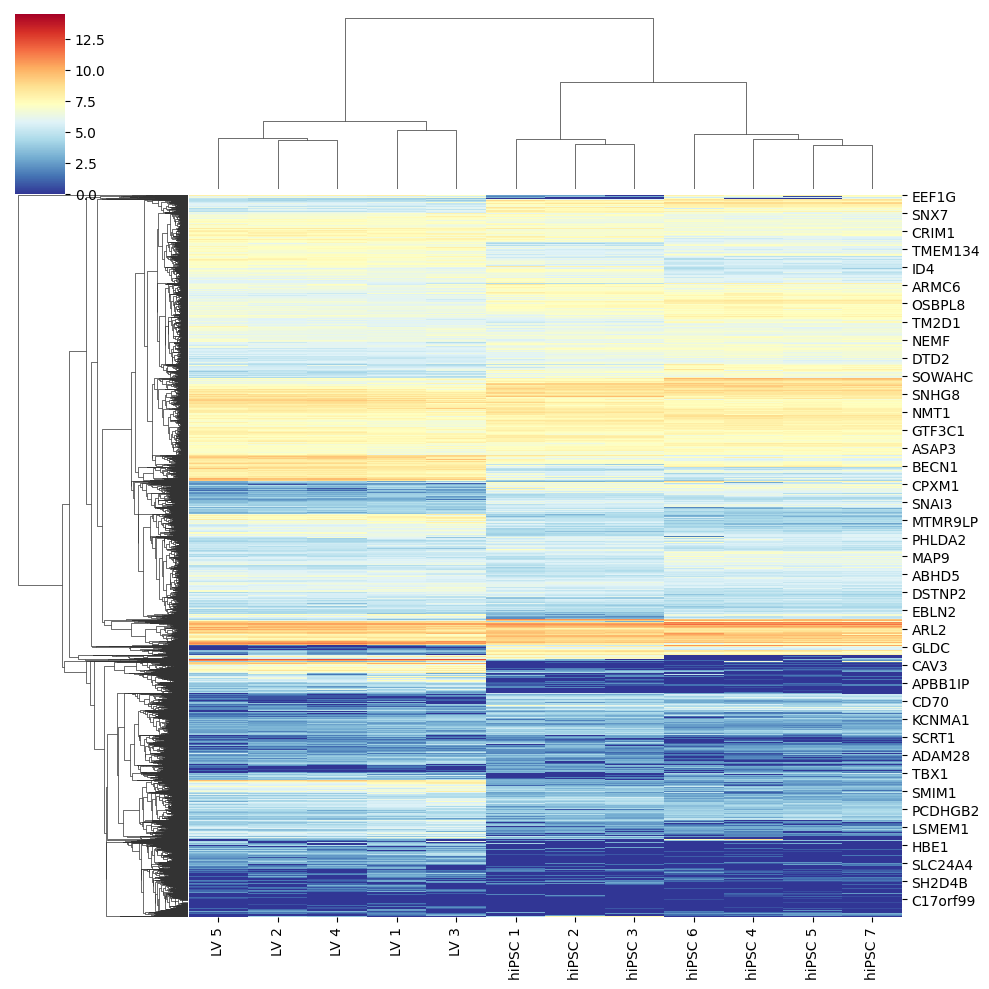

In [ ]:
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds_res = dds[:, res.index]

pattern_repetitions = {'LV': 5, 'hiPSC': 7}
col_labels = [f'{pattern} {i}' for pattern, repetitions in pattern_repetitions.items() for i in range(1, repetitions + 1)]

grapher_res = pd.DataFrame(dds_res.layers['log1p'].T,
                       index=dds_res.var_names, columns=col_labels)

sns.clustermap(grapher_res, cmap='RdYlBu_r')

# Heatmap of cardiac genes

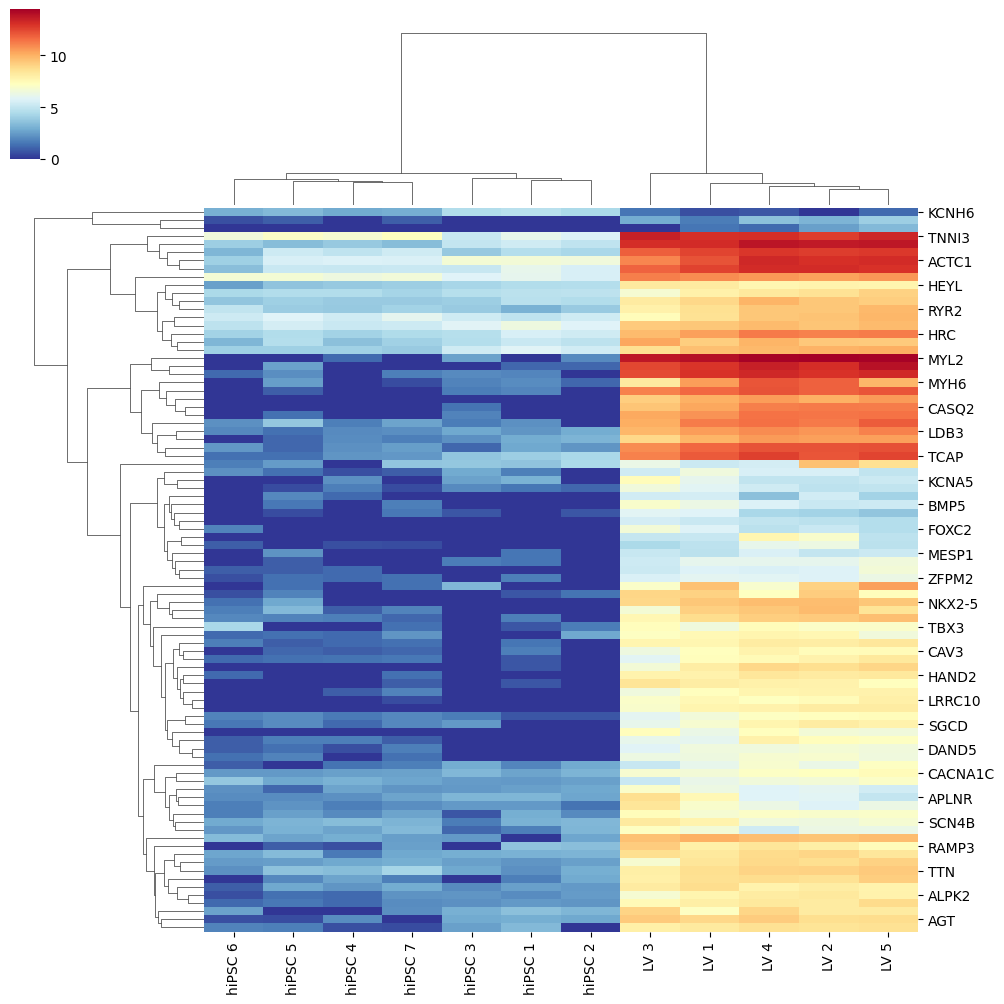

In [ ]:
cardiac_genes = pd.read_csv('dataset/cardiac_genes.csv', delimiter='\t')
common_genes = cardiac_genes['Gene'][cardiac_genes['Gene'].isin(grapher_res.index)]
subset_grapher_res = grapher_res.loc[common_genes]

sns.clustermap(subset_grapher_res, cmap='RdYlBu_r',cbar_pos=(0, .85, .03, .15))

# Differentially Expressed Genes

In [ ]:
#Filter based on p-value
ranking = res[res['pvalue'] <= 0.05]

#Sort based on abs log2 fold change
ranking = ranking[['log2FoldChange']].dropna()
ranking['abs_l2FC'] = ranking['log2FoldChange'].abs()
ranking.sort_values(by='abs_l2FC', ascending=False, inplace=True)
ranking = ranking[ranking['abs_l2FC'] > 1]

ranking.drop(columns=['abs_l2FC'], inplace=True)


ranking

,log2FoldChange
MYL2,18.957822
MYH7,17.875692
LIN28A,-17.516846
ANKRD2,17.502803
HSPB3,17.437420
...,...
MANEA,-1.001432
B3GAT3,1.001179
SSU72,-1.001070
VPS4B,-1.000993


In [ ]:
#Filter based on p-value
ranking = res[res['pvalue'] <= 0.05]

#Sort based on abs log2 fold change
ranking = ranking[['log2FoldChange']].dropna()
ranking['abs_l2FC'] = ranking['log2FoldChange'].abs()
ranking.sort_values(by='abs_l2FC', ascending=False, inplace=True)
ranking = ranking[ranking['abs_l2FC'] > 5]

ranking.drop(columns=['abs_l2FC'], inplace=True)


ranking

,log2FoldChange
MYL2,18.957822
MYH7,17.875692
LIN28A,-17.516846
ANKRD2,17.502803
HSPB3,17.437420
...,...
FOSL2,5.009478
SHOX2,5.007828
SOX4,-5.001473
SNX10,-5.000622


In [ ]:
pre_res = gp.prerank(rnk=ranking, # or rnk = rnk,
                     gene_sets='GO_Biological_Process_2021',
                     threads=4,
                     min_size=5,
                     max_size=1000,
                     permutation_num=1000, # reduce number to speed up testing
                     outdir=None, # don't write to disk
                     seed=6,
                     verbose=True, # see what's going on behind the scenes
                    )

2024-04-09 15:34:08,878 [INFO] Parsing data files for GSEA.............................
2024-04-09 15:34:08,885 [INFO] Enrichr library gene sets already downloaded in: /root/.cache/gseapy, use local file
2024-04-09 15:34:09,087 [INFO] 4622 gene_sets have been filtered out when max_size=1000 and min_size=5
2024-04-09 15:34:09,094 [INFO] 1414 gene_sets used for further statistical testing.....
2024-04-09 15:34:09,096 [INFO] Start to run GSEA...Might take a while..................
2024-04-09 15:34:38,958 [INFO] Congratulations. GSEApy runs successfully................



In [ ]:
out = []

for term in list(pre_res.results):
    out.append([term,
               pre_res.results[term]['fdr'],
               pre_res.results[term]['es'],
               pre_res.results[term]['nes'],
               pre_res.results[term]['gene %'],
               pre_res.results[term]['lead_genes'],])

out_df = pd.DataFrame(out, columns = ['Term','fdr', 'es', 'nes','gene %','lead_genes']).sort_values('nes').reset_index(drop = True)

out_df['abs_nes'] = abs(out_df['nes'])  # Create a new column with absolute NES values
out_df = out_df.sort_values('nes', ascending=False).reset_index(drop=True)

out_df.drop('abs_nes', axis=1, inplace=True)

out_df.to_csv('GSEA/OG_primary_new.tsv', sep='\t', index=False)

out_df

,Term,fdr,es,nes,gene %,lead_genes
0,muscle contraction (GO:0006936),0.0,0.658570,3.749324,20.01%,MYL2;MYH7;ANKRD2;CASQ2;MYL3;MYBPC3;LMOD2;KLHL4...
1,myofibril assembly (GO:0030239),0.0,0.667564,3.170572,13.57%,MYL2;MYOZ2;CSRP3;LMOD2;KLHL41;MYH6;LMOD3;TCAP;...
2,actin-myosin filament sliding (GO:0033275),0.0,0.712349,3.135282,14.01%,MYL2;MYH7;MYL3;MYBPC3;MYH6;DES;TCAP;TNNT3;TNNT...
3,muscle filament sliding (GO:0030049),0.0,0.712349,3.135282,14.01%,MYL2;MYH7;MYL3;MYBPC3;MYH6;DES;TCAP;TNNT3;TNNT...
4,striated muscle contraction (GO:0006941),0.0,0.692564,3.063905,8.88%,MYH7;CASQ2;MYL3;MYBPC3;CSRP3;KLHL41;MYH6;LMOD3...
...,...,...,...,...,...,...
1409,regulation of cell cycle process (GO:0010564),0.0,-0.637672,-3.293571,23.87%,CDC25C;NEK2;INSM1;BUB1;RMI2;AURKB;KIF20A;MKI67...
1410,mitotic metaphase plate congression (GO:0007080),0.0,-0.819342,-3.402641,18.59%,KIF14;KIF18A;CDT1;CENPE;NUF2;CEP55;CCNB1;NDC80...
1411,mitotic sister chromatid segregation (GO:0000070),0.0,-0.693884,-3.859361,22.69%,DLGAP5;KIF14;KIF18A;NCAPG;CENPE;CENPK;CEP55;NC...
1412,microtubule cytoskeleton organization involved...,0.0,-0.749876,-4.899442,26.16%,DLGAP5;KIF18A;TTK;CENPF;BUB1B;BUB1;BIRC5;AURKB...


In [ ]:
filtered_df = out_df[out_df['Term'].str.contains('heart|cardiac', case=False)]

filtered_df

,Term,fdr,es,nes,gene %,lead_genes
6,heart contraction (GO:0060047),0.000000,0.681276,2.972022,18.98%,MYL2;MYH7;CASQ2;MYL3;MYBPC3;CSRP3;MYH6;TCAP;TN...
7,heart development (GO:0007507),0.000000,0.547342,2.960031,21.57%,MYL2;MYH7;MYBPC3;CSRP3;MYH6;TBX2;TCAP;SOX17;LD...
9,ventricular cardiac muscle tissue development ...,0.000000,0.746082,2.765630,14.01%,MYL2;MYH7;MYL3;MYBPC3;MYH6;HOPX;TNNT2;TNNC1;HA...
10,regulation of heart contraction (GO:0008016),0.000000,0.587797,2.747892,14.89%,CASQ2;MYH6;HSPB7;TNNI3K;DES;PLN;TBX2;NKX2-5;TN...
11,cardiac muscle tissue morphogenesis (GO:0055008),0.000089,0.636322,2.699512,14.01%,MYL2;MYH7;MYL3;MYBPC3;MYH6;TCAP;NKX2-5;TNNT2;T...
12,cardiac muscle contraction (GO:0060048),0.000164,0.630847,2.603590,8.88%,MYH7;CASQ2;MYL3;MYBPC3;CSRP3;MYH6;TCAP;TNNT2;T...
13,ventricular cardiac muscle tissue morphogenesi...,0.000229,0.630939,2.511775,8.64%,MYL2;MYH7;MYL3;MYBPC3;MYH6;NKX2-5;TNNT2;TNNC1;...
15,cardiac muscle cell development (GO:0055013),0.000400,0.685886,2.470182,23.96%,MYL2;CSRP3;MYH6;LRRC10;TCAP;NKX2-5;ACTC1;ALPK2...
19,regulation of cardiac conduction (GO:1903779),0.002028,0.687941,2.333441,14.89%,CASQ2;TNNI3K;NKX2-5;NPPA;FXYD1;AGT;CORIN;ACE2
20,adult heart development (GO:0007512),0.002236,0.951076,2.326194,5.12%,MYH7;MYH6;TCAP;NKX2-5;HAND2
